## 1. Import Libraries

In [1]:
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from datetime import datetime as dt
from binance import Client
import joblib
import csv
import warnings
import os
warnings.filterwarnings("ignore")

## 2. Fetch Cryptocurrencies Data

In [2]:
# Configuración del cliente de Binance
client = Client(None, None)

# Lista de criptomonedas a analizar
cryptos = ["ETHUSDT", "LTCUSDT", "ADAUSDT", "XRPUSDT"]

# Funciones para obtener y guardar datos
def getdata(symbol, period, start, end):
    return client.get_historical_klines(symbol, period, start, end)

def make_csv(symbol, candles):
    with open("historical/"+symbol + ".csv", "w", newline="") as csvfile:
        cursor = csv.writer(csvfile)
        cursor.writerows(candles)

def multiple_csv(symbols, interval, start, end):
    for symbol in symbols:
        make_csv(symbol, getdata(symbol, interval, start, end))
        print(symbol, "CSV listo.")

def calculate_time(timestamp):
    return dt.fromtimestamp(timestamp / 1000)

In [ ]:
# Obtener datos históricos
multiple_csv(cryptos, client.KLINE_INTERVAL_1HOUR, "1 January 2010", "31 January 2025")

## 3. Predict with the Optimized LSTM Model

408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


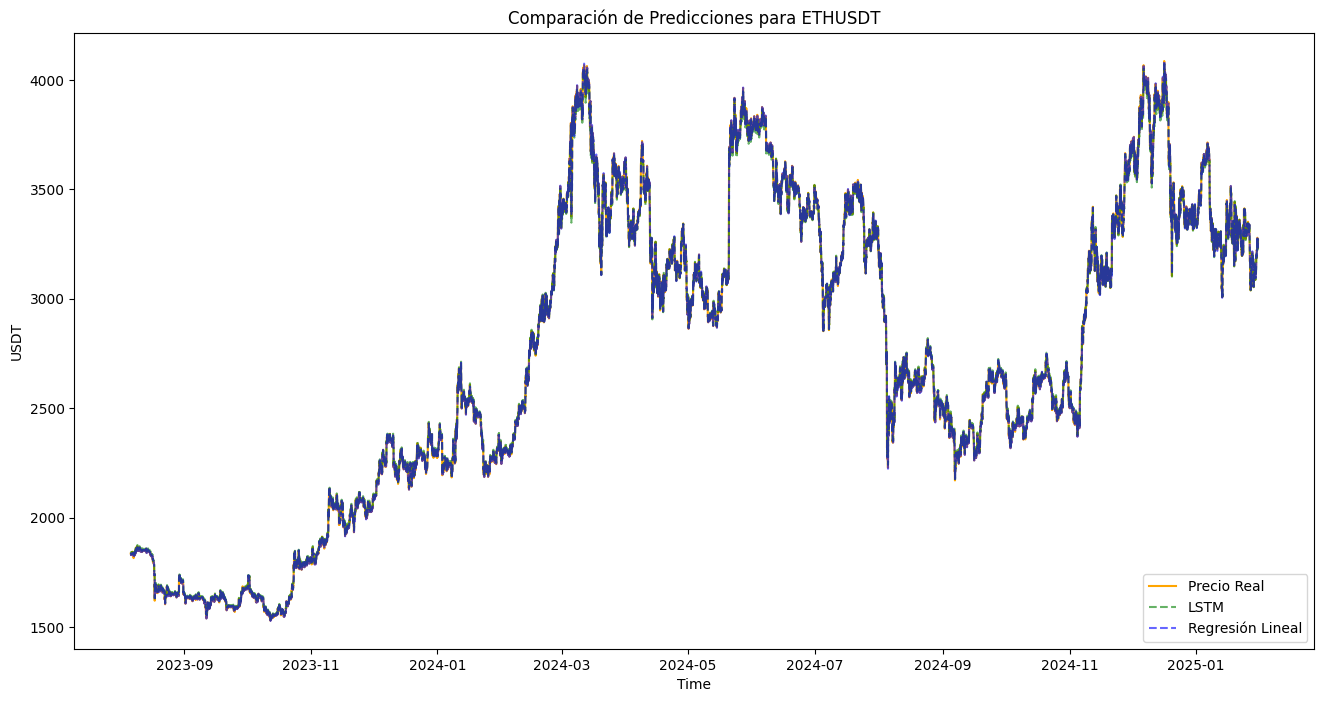

391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


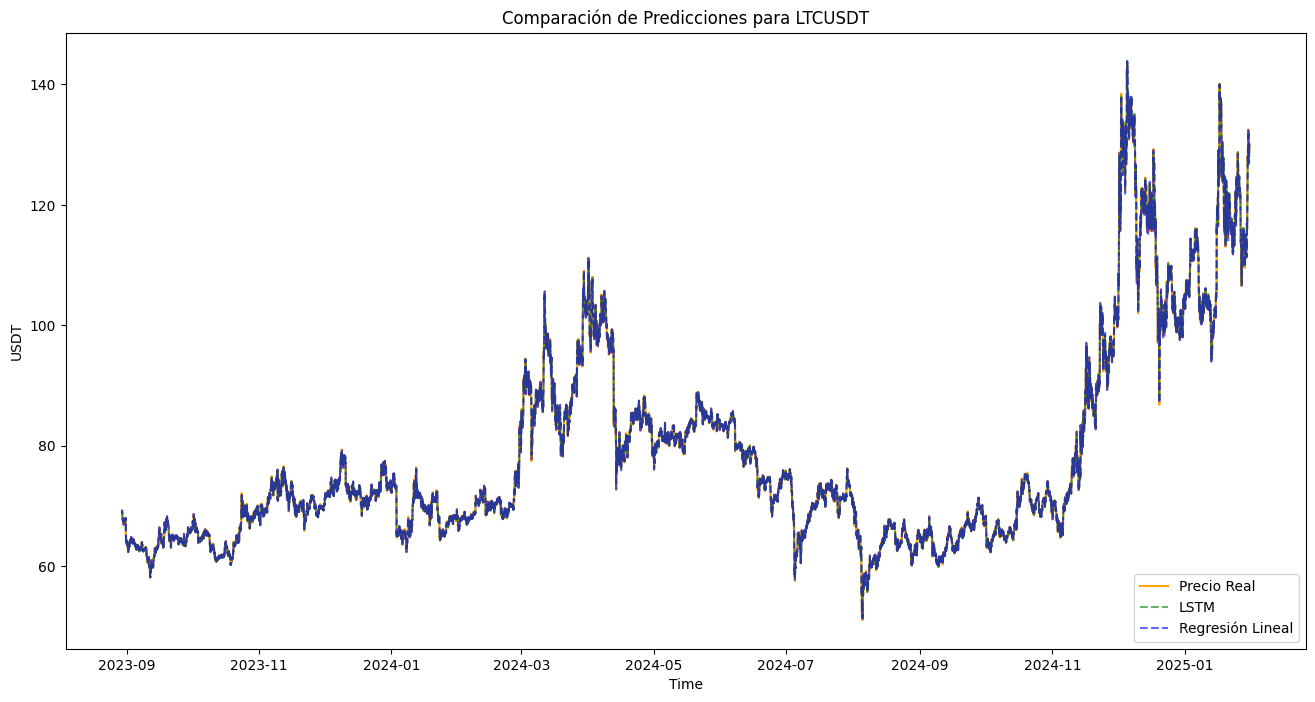

372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step


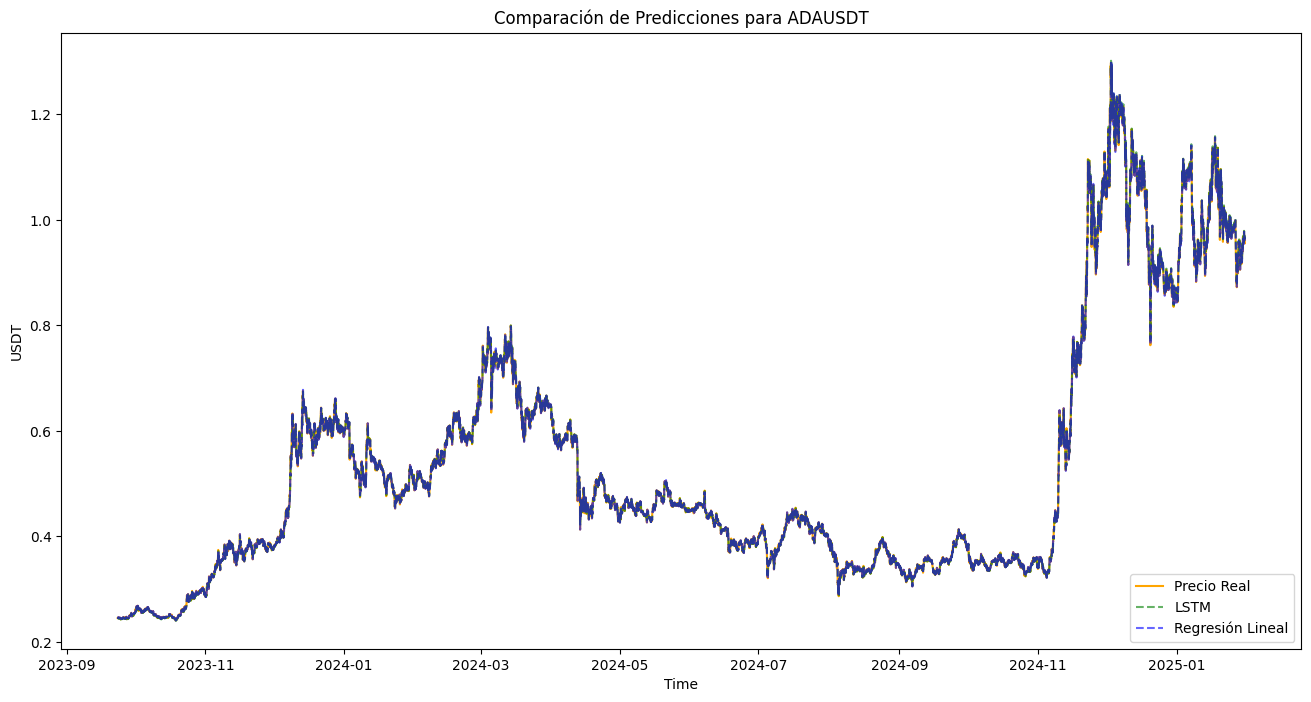

369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step


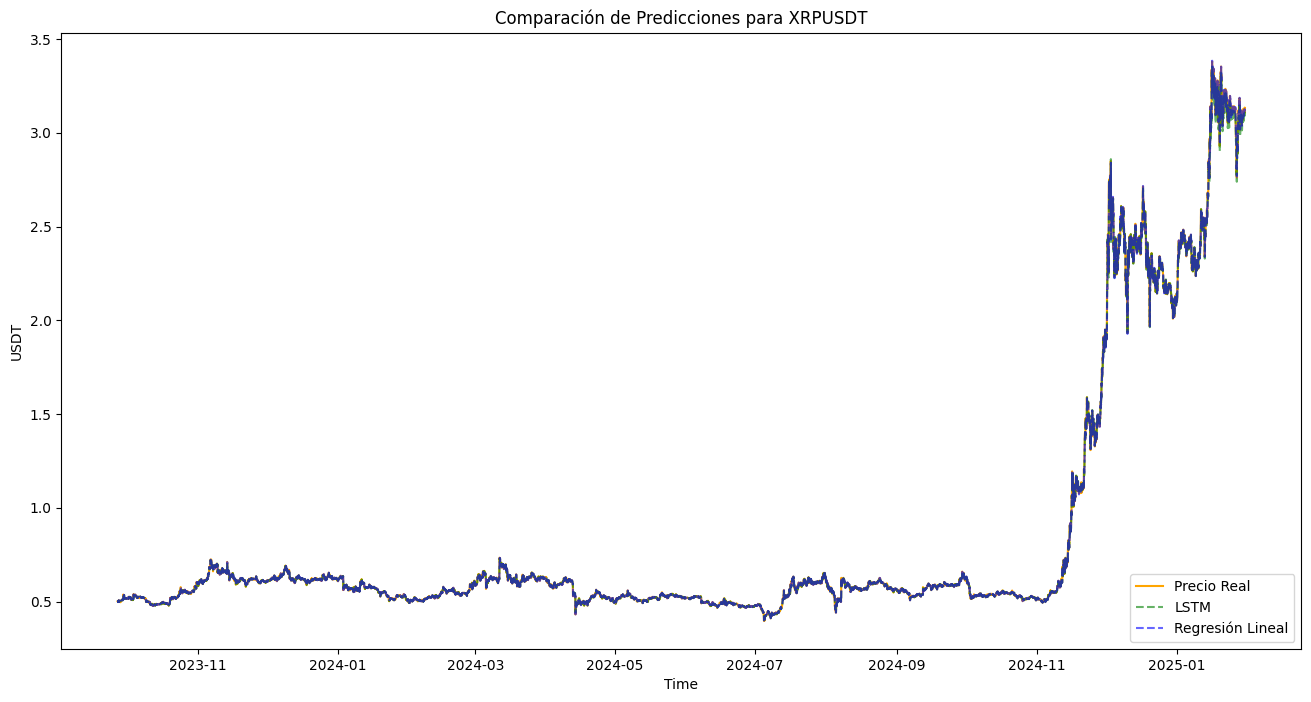

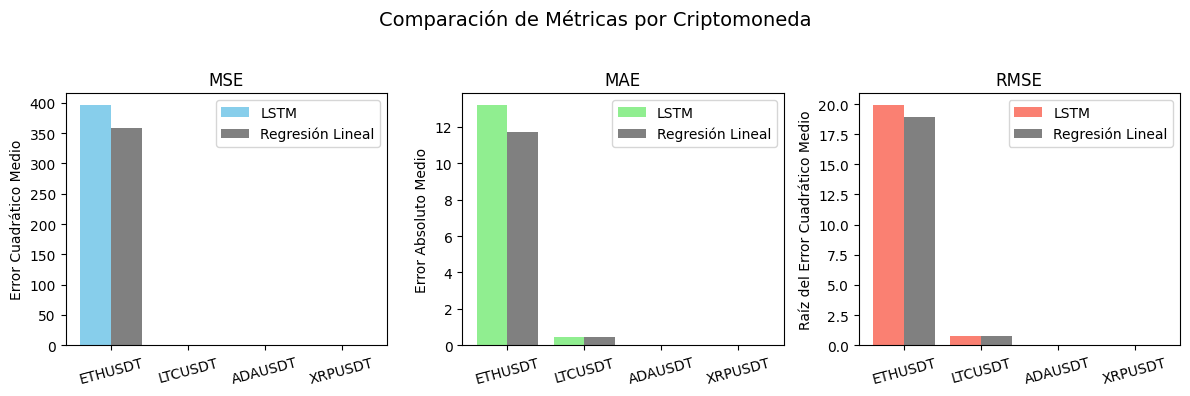

In [4]:
# Cargar modelo de regresión lineal
linreg_model = joblib.load("weights/linear_regression_model.pkl")

# Listas para métricas de cada criptomoneda
mse_list_lstm, rmse_list_lstm, mae_list_lstm = [], [], []
mse_list_linreg, rmse_list_linreg, mae_list_linreg = [], [], []

# Procesamiento y entrenamiento para cada criptomoneda
X_train = np.load("data/X_train.npy")
for crypto in cryptos:
    archivo_csv = f"historical/{crypto}.csv"
    if os.path.exists(archivo_csv):
        headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
        data = pd.read_csv(archivo_csv, names=headers)
        data["Open Time"] = data["Open Time"].apply(calculate_time)
        data["Close Time"] = data["Close Time"].apply(calculate_time)
        close = data.filter(["Close"])
        close_array = close.values
        train_close_len = math.ceil(len(close_array) * 0.8)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(close_array)
        train_data = scaled_data[:train_close_len, :]
        
        wz = 24*7
        test_data = scaled_data[train_close_len - wz:, :]
        X_test = [test_data[i - wz:i, 0] for i in range(wz, len(test_data))]
        X_test = np.array(X_test)
        y_test = scaled_data[train_close_len:, 0]
        
        # Construcción del modelo LSTM
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(100, return_sequences=False))
        model.add(Dense(50))
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mean_squared_error")
        
        # Cargar pesos del modelo optimizado
        model.load_weights("weights/optimized_model.weights.h5")
        
        # Predicciones LSTM
        predictions_lstm = model.predict(X_test)
        predictions_lstm = scaler.inverse_transform(predictions_lstm)
        
        # Predicciones Regresión Lineal
        predictions_linreg = linreg_model.predict(X_test.reshape(X_test.shape[0], -1))
        predictions_linreg = scaler.inverse_transform(predictions_linreg.reshape(-1, 1))
        
        # Visualización
        dates = np.array(data["Close Time"].values)
        valid = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        plt.figure(figsize=(16, 8))
        plt.title(f"Comparación de Predicciones para {crypto}")
        plt.xlabel("Time")
        plt.ylabel("USDT")
        plt.plot(dates[train_close_len:], valid, color="orange", label="Precio Real")
        plt.plot(dates[train_close_len:], predictions_lstm, alpha=0.6, color="green", label="LSTM", linestyle="--")
        plt.plot(dates[train_close_len:], predictions_linreg, alpha=0.6, color="blue", label="Regresión Lineal", linestyle="--")
        plt.legend(loc="lower right")
        plt.show()
        
        mse_lstm = np.mean(np.square(valid - predictions_lstm))
        rmse_lstm = math.sqrt(mse_lstm)
        mae_lstm = np.mean(np.abs(valid - predictions_lstm))
        
        mse_linreg = np.mean(np.square(valid - predictions_linreg))
        rmse_linreg = math.sqrt(mse_linreg)
        mae_linreg = np.mean(np.abs(valid - predictions_linreg))
        
        mse_list_lstm.append(mse_lstm)
        rmse_list_lstm.append(rmse_lstm)
        mae_list_lstm.append(mae_lstm)
        
        mse_list_linreg.append(mse_linreg)
        rmse_list_linreg.append(rmse_linreg)
        mae_list_linreg.append(mae_linreg)

# Comparación de métricas
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Comparación de Métricas por Criptomoneda", fontsize=14)

x = np.arange(len(cryptos))
width = 0.4

# MSE
axes[0].bar(x - width/2, mse_list_lstm, width, label="LSTM", color="skyblue")
axes[0].bar(x + width/2, mse_list_linreg, width, label="Regresión Lineal", color="gray")
axes[0].set_title("MSE")
axes[0].set_ylabel("Error Cuadrático Medio")
axes[0].set_xticks(x)
axes[0].set_xticklabels(cryptos, rotation=15)
axes[0].legend()

# MAE
axes[1].bar(x - width/2, mae_list_lstm, width, label="LSTM", color="lightgreen")
axes[1].bar(x + width/2, mae_list_linreg, width, label="Regresión Lineal", color="gray")
axes[1].set_title("MAE")
axes[1].set_ylabel("Error Absoluto Medio")
axes[1].set_xticks(x)
axes[1].set_xticklabels(cryptos, rotation=15)
axes[1].legend()

# RMSE
axes[2].bar(x - width/2, rmse_list_lstm, width, label="LSTM", color="salmon")
axes[2].bar(x + width/2, rmse_list_linreg, width, label="Regresión Lineal", color="gray")
axes[2].set_title("RMSE")
axes[2].set_ylabel("Raíz del Error Cuadrático Medio")
axes[2].set_xticks(x)
axes[2].set_xticklabels(cryptos, rotation=15)
axes[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 4. Classify Buy/Sell Periods

432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


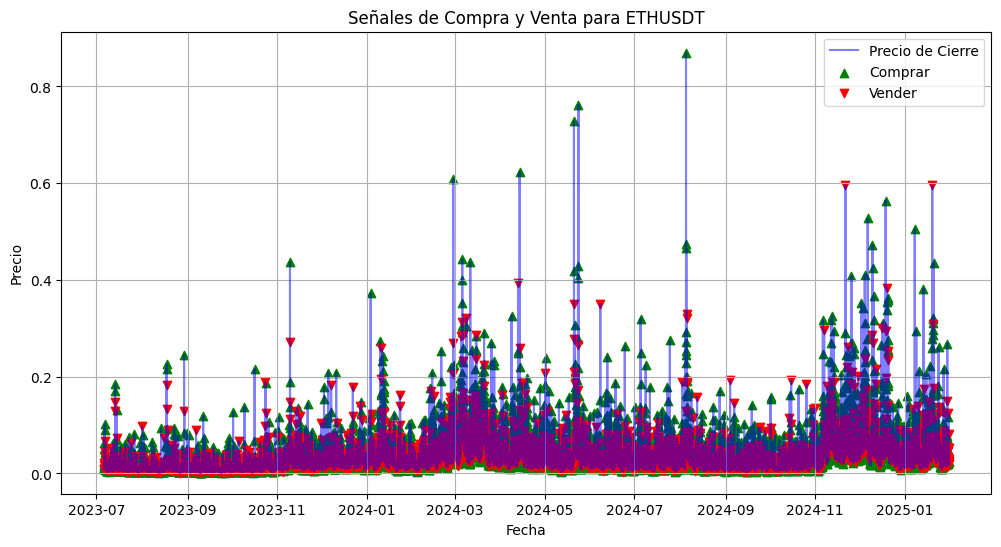

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


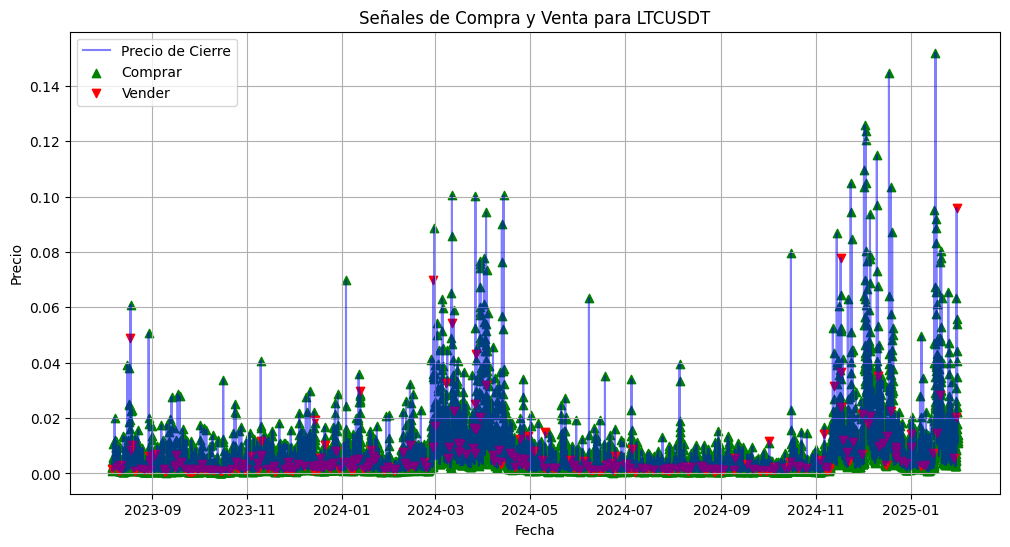

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


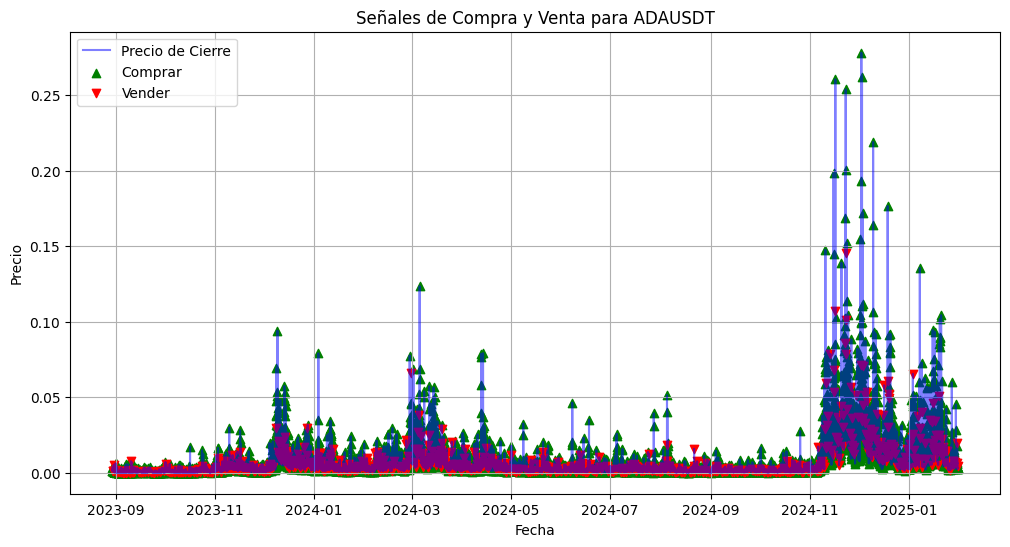

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


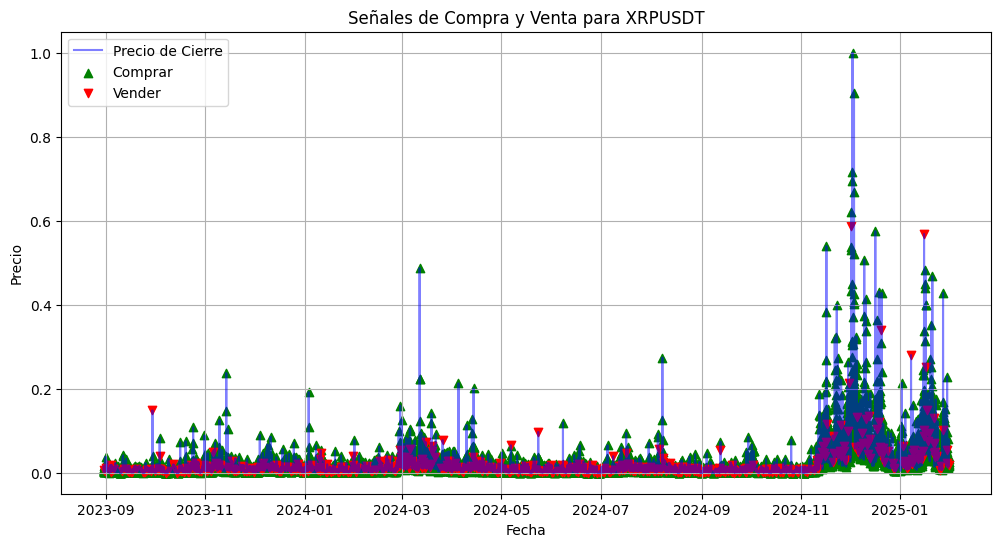

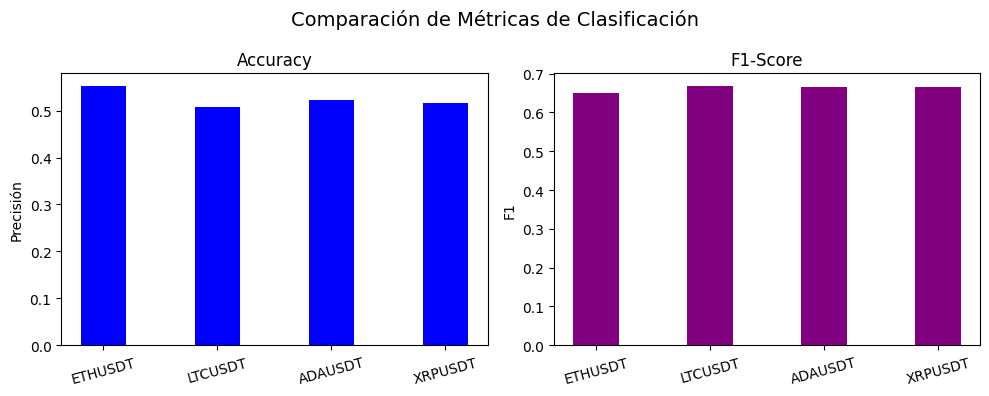

In [5]:
def calculate_time(timestamp):
    return pd.to_datetime(timestamp, unit='s')

# Cargar modelo y pesos
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(48, 11)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='gelu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights("weights/cyv_model.weights.h5")

# Listas para almacenar métricas
accuracy_list, f1_list = [], []

# Procesamiento y evaluación para cada criptomoneda
for crypto in cryptos:
    archivo_csv = f"historical/{crypto}.csv"
    if os.path.exists(archivo_csv):
        # Cargar datos
        column_names = ["Timestamp", "Open", "High", "Low", "Close", "Volume"]
        df = pd.read_csv(archivo_csv, names=column_names, header=None)
        df["Timestamp"] = pd.to_numeric(df["Timestamp"], errors="coerce")
        df = df[df["Timestamp"] > 1000000000]
        if df["Timestamp"].max() > 10**12:
            df["Timestamp"] = df["Timestamp"] // 1000
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

        # Generar características
        wz = 48
        df["Price_Change"] = df["Close"] - df["Open"]
        df["High_Low_Spread"] = df["High"] - df["Low"]
        df["Pct_Change"] = df["Close"].pct_change()
        df["Future_Close"] = df["Close"].shift(-1)

        # Indicadores técnicos
        df["SMA_10"] = df["Close"].rolling(window=10).mean()
        df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
        df["Volatility"] = df["Close"].rolling(window=10).std()
        
        # Manejo de valores NaN o infinitos
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        # Generar etiquetas
        df["Signal"] = np.where(df["Future_Close"] > df["Close"], 1, 0)

        # Escalar datos
        features = ["Open", "High", "Low", "Close", "Volume", "Price_Change", "High_Low_Spread", "Pct_Change", "SMA_10", "EMA_10", "Volatility"]
        scaler = MinMaxScaler()
        df[features] = scaler.fit_transform(df[features])

        # Crear ventanas de datos
        X, y = [], []
        for i in range(len(df) - wz):
            X.append(df[features].iloc[i : i + wz].values)
            y.append(df["Signal"].iloc[i + wz])

        X, y = np.array(X), np.array(y)

        # Balanceo de clases con SMOTE
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)
        X_resampled = X_resampled.reshape(X_resampled.shape[0], wz, len(features))

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

        # Evaluación del modelo
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        df_test = df.iloc[-len(y_test):].copy()
        df_test["Prediction"] = y_pred.flatten()

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy_list.append(accuracy)
        f1_list.append(f1)

        # Visualización de predicciones
        plt.figure(figsize=(12,6))
        plt.plot(df_test["Timestamp"], df_test["Close"], label="Precio de Cierre", color="blue", alpha=0.5)
        plt.scatter(df_test[df_test["Prediction"] == 1]["Timestamp"], df_test[df_test["Prediction"] == 1]["Close"],
                    color="green", label="Comprar", marker="^", alpha=1)
        plt.scatter(df_test[df_test["Prediction"] == 0]["Timestamp"], df_test[df_test["Prediction"] == 0]["Close"],
                    color="red", label="Vender", marker="v", alpha=1)
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.title(f"Señales de Compra y Venta para {crypto}")
        plt.legend()
        plt.grid()
        plt.show()

# Comparación de métricas de clasificación
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Comparación de Métricas de Clasificación", fontsize=14)

x = np.arange(len(cryptos))
width = 0.4

# Accuracy
axes[0].bar(x, accuracy_list, width, color="blue")
axes[0].set_title("Accuracy")
axes[0].set_ylabel("Precisión")
axes[0].set_xticks(x)
axes[0].set_xticklabels(cryptos, rotation=15)

# F1-Score
axes[1].bar(x, f1_list, width, color="purple")
axes[1].set_title("F1-Score")
axes[1].set_ylabel("F1")
axes[1].set_xticks(x)
axes[1].set_xticklabels(cryptos, rotation=15)

plt.tight_layout()
plt.show()